In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt
import os

import glob as glob
import pandas as pd
import torchvision
from torchvision.io import read_video as read_video
from torchvision.io import write_video as write_video

In [2]:
root_path = "/Users/andrew/Desktop/cs196/RWF2000_short_version/*"

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, train = True): 
        self.n_frames_per_video = 150 
        
        self.paths = [] 
        folder = glob.glob(root_path)
        
        for folder in folder:
            if train == ("train" in folder): 
                sub_folders = glob.glob(folder + "/*")
                for sub_folder in sub_folders:
                    files = glob.glob(sub_folder + "/*.avi")
                    for file in files:
                        self.paths.append(file)
        self.data = []
        for path in self.paths:
            self.data.append(read_video(path))
    
    def __len__(self):
        return len(self.paths) * self.n_frames_per_video

    def __getitem__(self, idx):
        path_idx = idx // self.n_frames_per_video
        frame_idx = idx % self.n_frames_per_video
        
        video_data = self.data[path_idx][0]
        frame_data = video_data[frame_idx]
        
        path = self.paths[path_idx]
        label = not 'NonFight' in path # label == True == 1 -> 1 means there is a fight
        
        return frame_data, label #image, label

In [4]:
train_set = CustomImageDataset(train = True)
test_set = CustomImageDataset(train = False)

True


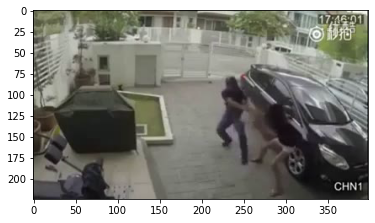

In [5]:
plt.imshow(train_set[100][0]) #show the 100th frame in training set
print(train_set[100][1]) #show the 100th frame's label in training set

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
    
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7*7*64, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        #224x224
        x = self.pool(F.relu(self.conv1(x))) #112x112
        x = self.pool(F.relu(self.conv2(x))) #56x56
        x = self.pool(F.relu(self.conv3(x))) #28x28
        x = self.pool(F.relu(self.conv4(x))) #14x14
        x = self.pool(F.relu(self.conv5(x))) #7x7
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.sigmoid(x)
        return x

x = torch.rand(1,3,224,224)
model = Net()
model(x)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[0.4979]], grad_fn=<SigmoidBackward>)

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool3d(2)
        self.pool_last = nn.MaxPool3d(2,padding=(1,0,0))
        
        self.conv1 = nn.Conv3d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv3d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv3d(64, 64, 3, padding=1)
    
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7*7*64, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        #20x224x224
                                      
        x = self.pool(F.relu(self.conv1(x))) #10x112x112
        x = self.pool(F.relu(self.conv2(x))) #5x56x56
        x = self.pool(F.relu(self.conv3(x))) #2x28x28
        x = self.pool(F.relu(self.conv4(x))) #1x14x14
        x = self.pool_last(F.relu(self.conv5(x))) #1x7x7
        print(x.shape)
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.sigmoid(x)
        return x

x = torch.ones(1,3,20,224,224)
model = Net()


In [8]:
model(x)

torch.Size([1, 64, 1, 7, 7])


tensor([[0.4771]], grad_fn=<SigmoidBackward>)

In [9]:
b, t, c, h, w = x.shape
x = x.reshape(b, t*c, h, w)
x.shape

torch.Size([1, 60, 224, 224])

In [14]:
def conv3113(channels: list, stride: int = 1, groups: int = 1, dilation: int = 1):
    '''3x3 convolution with padding'''
    assert len(channels) == 3
    return nn.Sequential(
        nn.Conv2d(
            channels[0],
            channels[0],
            kernel_size=(3,1),
            stride=stride,
            padding=(1.0),
            groups=groups,
            bias=True,
            dilation=dilation,
        ),
        nn.Conv2d(
            channels[0],
            channels[1],
            kernel_size=(1,1),
            stride=stride,
            padding=0,
            groups=groups,
            bias=True,
            dilation=dilation,
        ),
        nn.Conv2d(
            channels[1],
            channels[2],
            kernel_size=(1,1),
            stride=stride,
            padding=0,
            groups=groups,
            bias=True,
            dilation=dilation,
        ),
        nn.Conv2d(
            channels[2],
            channels[2],
            kernel_size=(1,3),
            stride=stride,
            padding=(0,1),
            groups=groups,
            bias=True,
            dilation=dilation,
        )
    )

class Block(nn.Module):
    def __init__(self, in_chan, mid_chan, intermediate_chan, out_chan, stride=1, downsample=None, groups=1, dialation=1, norm_layer=None):
        super().__init__()
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.relu=nn.ReLU(inplace=True)
        
        self.conv1 = conv3113([in_chan, mid_chan, intermediate_chan])
        self.bn1 = norm_layer(intermediate_chan)
        
        self.conv2 = conv3113([intermediate_chan, mid_chan, intermediate_chan])
        self.bn2 = norm_layer(intermediate_chan)
        
        self.conv3 = conv3113([intermediate_chan, mid_chan, out_chan])
        self.bn3 = norm_layer(out_chan)
        
        self.conv_resetchan = nn.Conv2d(in_chan+out_chan, out_chan, kernel_size=1, padding=0)

    def forward(self, x):
        identity = x
        #print(identity.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        #print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        x = torch.cat([identity, x], dim=1)
        x = self.conv_resetchan(x)
        
        x = self.relu(x)
        
        return x
    
class Net(nn.Module):
    def __init__(self, block, n_blocks, block_params, resolution, norm_layer=None):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.maxpool_every = 3
        self.blocks = nn.ModuleList([])
        in_chan, mid_chan, intermediate_chan, out_chan = block_params
        
        self.conv1 = nn.Conv2d(3, in_chan, 3, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        block_in_chan = [0, in_chan]
        for i in range(1, n_blocks+1):
            self.blocks.append(
                nn.Sequential(
                    Block(block_in_chan[-1], mid_chan, intermediate_chan, in_chan),
                    Block(in_chan, mid_chan, intermediate_chan, in_chan),
                    Block(in_chan, mid_chan, intermediate_chan, out_chan),
                    
                )
            )
            block_in_chan.append(out_chan)
        print(block_in_chan)
        self.fc = nn.Linear(block_in_chan[-1]*(256 // 2**(n_blocks//3))**2, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,32)
        self.fc4 = nn.Linear (32,1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        for i, block_group in enumerate(self.blocks):
            print("bik: ", i, x.shape)
            iden = x
            x = block_group(x)
            x += iden
            
            if i%self.maxpool_every == self.maxpool_every-1:
                x = self.maxpool(x)

                
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        x = torch.sigmoid(x)
        
        return x

res = 224
net = Net(Block, 15, [32, 1024, 64, 32], res)

[0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]


In [21]:
sum(p.numel() for p in net.parameters())

18621569

In [22]:
net(torch.zeros(1,3,res,res))

bik:  0 torch.Size([1, 32, 224, 224])


TypeError: conv2d() received an invalid combination of arguments - got (Tensor, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [23]:
from torchviz import make_dot

In [24]:
for x in list(net.modules())[-5:]:
    print(x, sum(p.numel() for p in x.parameters()))

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0
Linear(in_features=2048, out_features=512, bias=True) 1049088
Linear(in_features=512, out_features=128, bias=True) 65664
Linear(in_features=128, out_features=32, bias=True) 4128
Linear(in_features=32, out_features=1, bias=True) 33


In [25]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

18621569

In [26]:
for layer in net.modules():
    print(layer, sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Block(
        (relu): ReLU(inplace=True)
        (conv1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
          (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
          (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
          (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        )
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
          (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
          (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
          (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        )
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Sequential(


) 18621569
Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Block(
  (relu): ReLU(inplace=True)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_si

Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
  (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
) 18621569
Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
  (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1024, 32, kernel_s

) 18621569
Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
  (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
) 18621569
Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Block(
  (relu): ReLU(inplace=True)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_size=(1, 1), 

) 18621569
Block(
  (relu): ReLU(inplace=True)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Block(
  (relu): ReLU(inplace=True)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): 

Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Block(
  (relu): ReLU(inplace=True)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0

) 18621569
Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
  (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
) 18621569
Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1)) 18621569
Block(
  (relu): ReLU(inplace=True)
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
    (1): Conv2d(64, 1024, kernel_size=(1, 1), 

Conv2d(32, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0))
  (1): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
) 18621569
Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1.0, 1.0)) 18621569
Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1)) 18621569
Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)) 18621569
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 18621569
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 1), stri

In [28]:
import torchvision.models as models
efficientnet_b6 = models.efficientnet_b6(pretrained = True)

AttributeError: module 'torchvision.models' has no attribute 'efficientnet_b6'